In [11]:
# do not read stringsAsFactors yet as subsetting and removing all instances of
# a level from the data.frame will cause randomForest to raise error.
zonal.stats <- read.table(
    '/data/mbp14mtp/raster_layers/training_seg_zonal_stats/zonal_stats_merged.tsv',
    sep='\t', header=TRUE, stringsAsFactors=FALSE)
# add perimeter / area variable
zonal.stats['perimeter_area_ratio'] <- zonal.stats$perimeter / zonal.stats$area

#ndvi summer variable
zonal.stats['summer_ndvi'] <- (zonal.stats$S2_summer_NIR_mean - zonal.stats$S2_summer_Red_mean) / (
                               zonal.stats$S2_summer_NIR_mean + zonal.stats$S2_summer_Red_mean)
zonal.stats['winter_ndvi'] <- (zonal.stats$S2_winter_NIR_mean - zonal.stats$S2_winter_Red_mean) / (
                               zonal.stats$S2_winter_NIR_mean + zonal.stats$S2_winter_Red_mean)


# remove low confidence training points - try conf <= 2 first
zonal.stats <- zonal.stats[zonal.stats$confidence <= 2,]

# replace nans with column median
for (i in 4:ncol(zonal.stats)) {
  zonal.stats[is.na(zonal.stats[,i]), i] <- median(zonal.stats[,i], na.rm = TRUE)
}
# set very large, negative values in SLOPE, HEIGHT and ASPECT to be zero
zonal.stats[zonal.stats < 0] <- 0

# now we can convert strings to factors
zonal.stats <- as.data.frame(unclass(zonal.stats), stringsAsFactors=TRUE)

head(zonal.stats)

,broadclass,class,confidence,S1_summer_vh_max,S1_summer_vh_min,S1_summer_vh_mean,S1_summer_vh_std,S1_summer_vv_max,S1_summer_vv_min,S1_summer_vv_mean,ellip.h,SLOPE_min,SLOPE_mean,SLOPE_std,HILLSHADE_max,HILLSHADE_min,HILLSHADE_mean,HILLSHADE_std,perimeter_area_ratio,summer_ndvi,winter_ndvi
1,Scrub and bracken,V05: Scrub of high environmental value,1,0.07,0.02,0.04,0.01,0.33,0.06,0.19,<8b>,12.85,20.2,3.63,169,115,145.23,12.54,0.06461538,0.9226503,0.8058453
2,Trees (in-field and boundary) orchard and woodland,T03: Wood-pasture and Parkland - BAP Habitat,1,0.13,0.01,0.03,0.02,0.31,0.02,0.1,<8b>,7.24,12.9,1.99,224,199,213.04,5.8,0.08051948,0.9048216,0.795622
3,Water,Sea,1,0.07,0.01,0.03,0.01,0.27,0.03,0.11,<8b>,0,0,1.88,255,255,255,0,0.03165093,0,0
4,Grassland,G11: Habitat for invertebrates,1,0.09,0.01,0.04,0.02,0.4,0.04,0.13,<8b>,7.58,14.95,4.62,195,120,158.54,21.78,0.06111111,0.9289048,0.6810909
5,Urban,Building,1,0.48,0,0.04,0.03,4.32,0.01,0.19,<8b>,0.06,5.66,3.34,218,99,172.79,12.43,0.04189189,0.6425292,0.6566677
6,Trees (in-field and boundary) orchard and woodland,T10: Lowland mixed deciduous woodland,1,0.08,0.01,0.04,0.01,0.31,0.05,0.17,<8b>,2.47,11.34,3.37,186,130,149.25,11.22,0.0256705,0.9441355,0.7238841


randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  

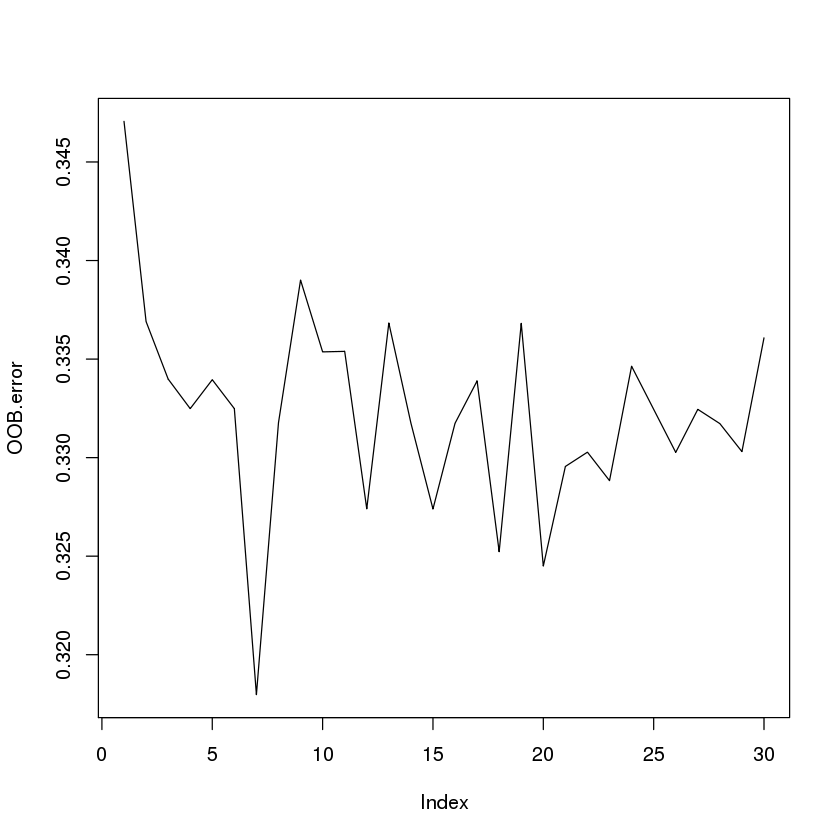

In [12]:
# fit random forests with different mtry to determine optimum parameter
library(randomForest)

mtry_max <- 30
OOB.error <- double(mtry_max)
for (mtry in 1:mtry_max) {
  set.seed(1001)
  fit.rf <- randomForest(broadclass ~ .,
                         data=zonal.stats[,c(1, 4:ncol(zonal.stats))],
                         mtry=mtry,
                         ntree=800)
  OOB.error[mtry] = 1 - sum(diag(fit.rf$confusion)) / sum(fit.rf$confusion)
  cat(mtry, " ")
}
plot(OOB.error, type='l')

In [20]:
# best mtry is around 5-8
set.seed(10)
fit.rf <- randomForest(broadclass ~ .,
                       data=zonal.stats[,c(1, 4:ncol(zonal.stats))],
                       mtry=6,
                       ntree=800)

fit.rf


Call:
 randomForest(formula = broadclass ~ ., data = zonal.stats[, c(1,      4:ncol(zonal.stats))], mtry = 6, ntree = 800) 
               Type of random forest: classification
                     Number of trees: 800
No. of variables tried at each split: 6

        OOB estimate of  error rate: 33.04%
Confusion matrix:
                                                   Beach Coastal
Beach                                                 30       1
Coastal                                                0      12
Field boundaries                                       0       0
Grassland                                              0       1
Heathland and moorland                                 0       3
Lower plant                                            0       0
Scrub and bracken                                      0       0
Trees (in-field and boundary) orchard and woodland     0       0
Urban                                                  0       1
Vascular plants            

In [22]:
# fit gradient boosted machine - we can use this to examine the importance
# of different variables
library(gbm)
source('./user_producer_accuracy.R')

set.seed(101)
frac <- randomSubset(zonal.stats, 0.8)
zs.train <- zonal.stats[frac,]
zs.test <- zonal.stats[-frac,]

fit.gbm <- gbm(broadclass ~ .,
               data=zs.train[,c(1, 4:ncol(zonal.stats))],
               distribution='multinomial',
               n.trees=1000,
               shrinkage=0.01,
               interaction.depth=4,
               cv.folds=2)

Using cv method...
[1] 350


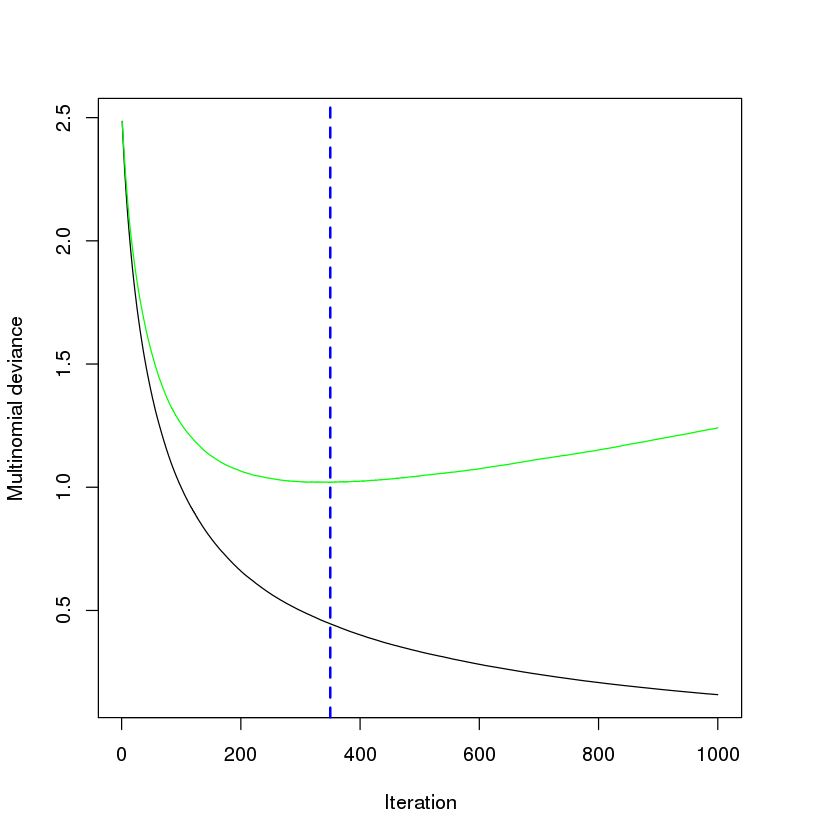

In [23]:
# how many trees are required for a good model?
ntrees <- gbm.perf(fit.gbm)
print(ntrees)

In [24]:
# Test the gbm
predicted.gbm <- predict(fit.gbm,
                         newdata=zs.test[,c(1, 4:ncol(zonal.stats))],
                         type='response',
                         n.trees=ntrees)
predicted.gbm.classes <- classFromProbs(predicted.gbm)
predicted.gbm.classes <- factor(predicted.gbm.classes, levels=levels(zs.test$broadclass))
confusionMatrix(zs.test$broadclass, predicted.gbm.classes)

ERROR: Error in vapply(seq_along(mapped), function(i) {: values must be length 1,
 but FUN(X[[1]]) result is length 0


$table
                                                    user
producer                                             Beach Coastal
  Beach                                                  4       0
  Coastal                                                1       4
  Field boundaries                                       0       0
  Grassland                                              0       4
  Heathland and moorland                                 0       0
  Lower plant                                            0       0
  Scrub and bracken                                      0       0
  Trees (in-field and boundary) orchard and woodland     0       0
  Urban                                                  0       0
  Vascular plants                                        0       0
  Water                                                  0       0
  Wetland                                                0       0
                                                    user
producer

Warning message:
In `[<-.factor`(`*tmp*`, ri, value = "<e2><8b><ae>"): invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, ri, value = "<e2><8b><ae>"): invalid factor level, NA generated

,var,rel.inf
S2_summer_SWIR2_mean,S2_summer_SWIR2_mean,7.799999901725
S2_summer_Green_mean,S2_summer_Green_mean,6.87553129442251
S2_summer_RedEdge5_mean,S2_summer_RedEdge5_mean,5.61834334729859
S2_summer_Blue_std,S2_summer_Blue_std,5.07088765268761
S2_summer_SWIR1_mean,S2_summer_SWIR1_mean,3.2566334269216
HEIGHT_max,HEIGHT_max,2.89234849459316
HEIGHT_mean,HEIGHT_mean,2.66040919341408
SLOPE_min,SLOPE_min,2.55292379478763
S1_winter_vv_mean,S1_winter_vv_mean,2.2076802629375
S1_summer_vv_mean,S1_summer_vv_mean,2.1993807883267


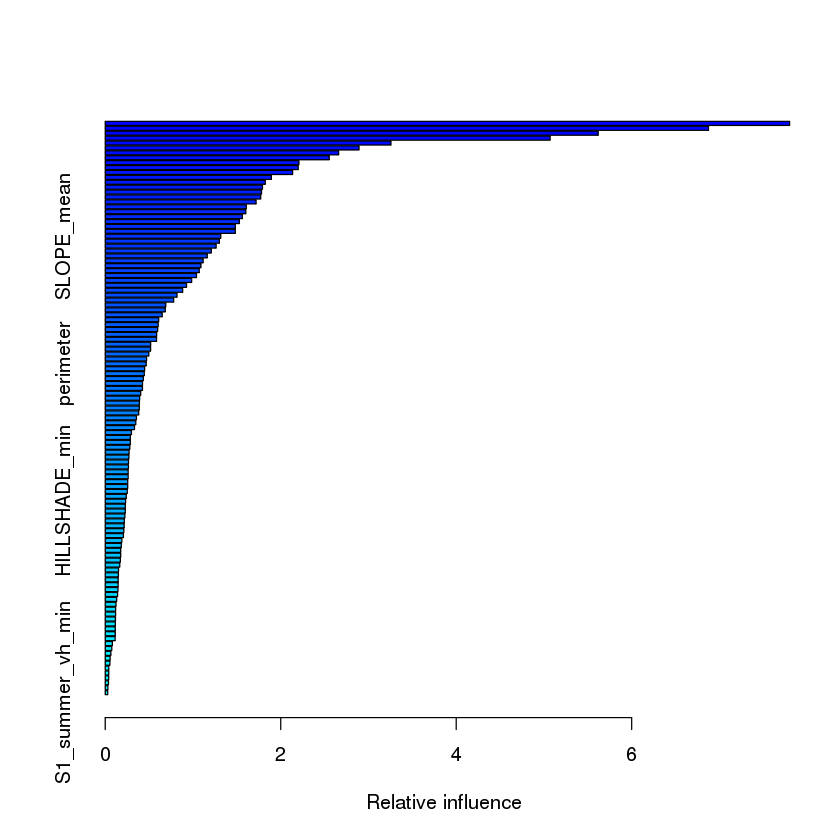

In [33]:
# look at the most important variables:
fit.gbm.summary <- summary(fit.gbm)
fit.gbm.summary

Warning message:
: package ‘ggplot2’ was built under R version 3.3.1
Attaching package: ‘ggplot2’

The following object is masked from ‘package:randomForest’:

    margin



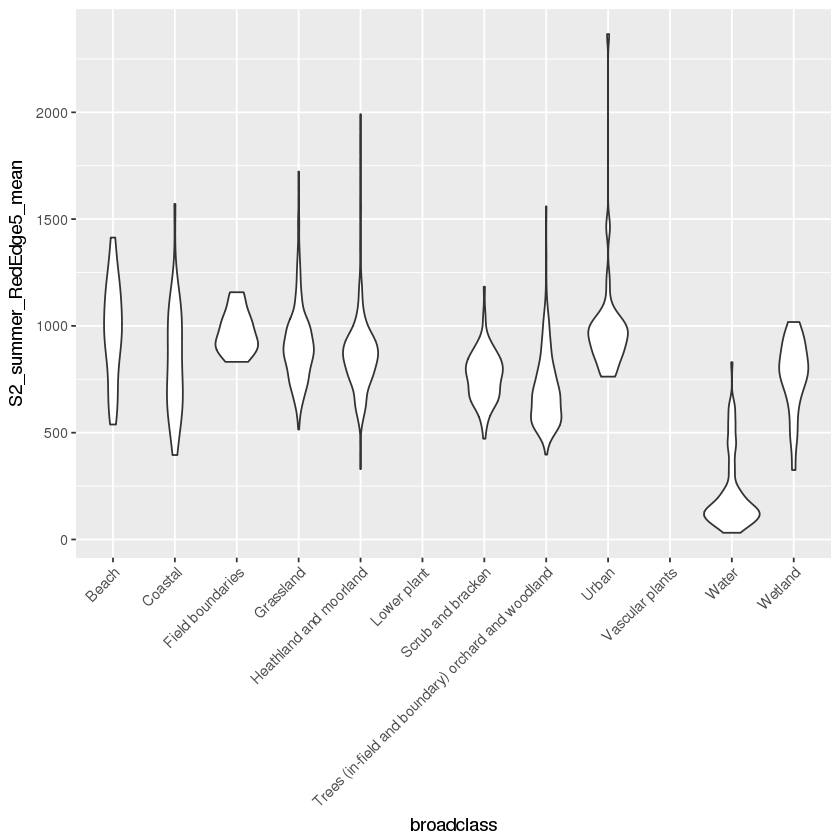

In [37]:
library(ggplot2)

plotviolin <- function(column) {
  g <- ggplot(zonal.stats, aes_string('broadclass', column))
  g <- g + geom_violin()
  g <- g + theme(axis.text.x = element_text(angle = 45, hjust = 1))
  g
}

# RedEdge5 looks important for classifying water
plotviolin('S2_summer_RedEdge5_mean')

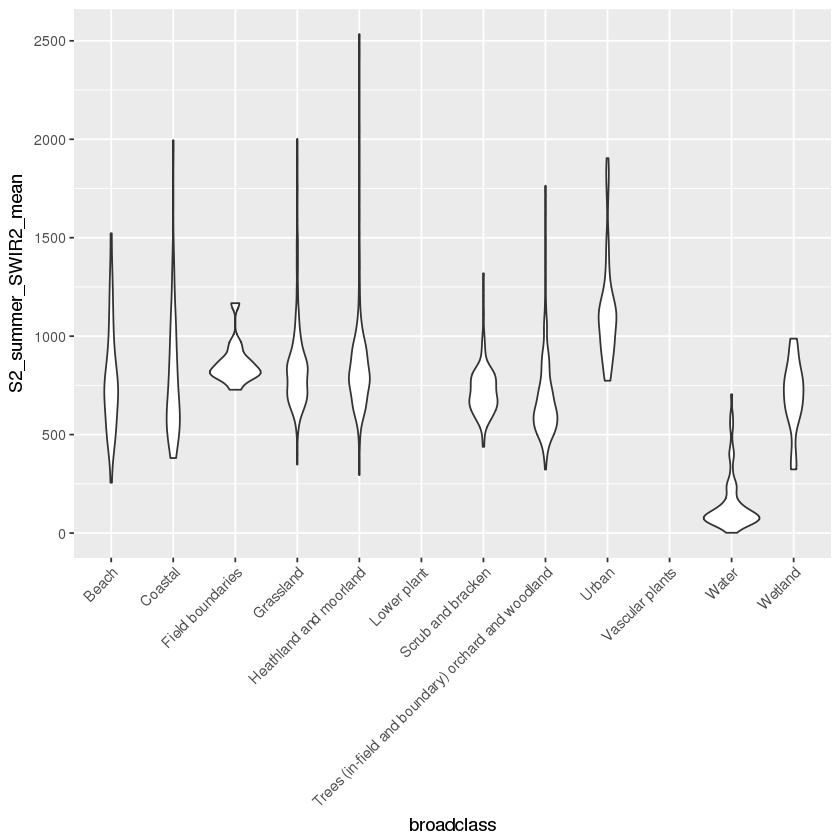

In [39]:
plotviolin('S2_summer_SWIR2_mean')

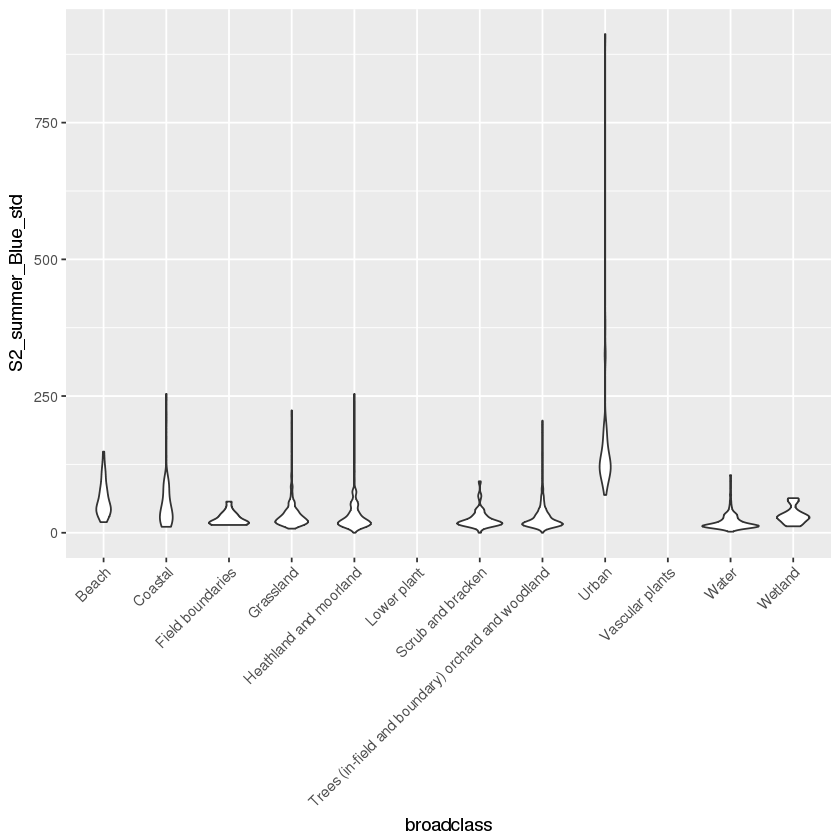

In [44]:
plotviolin('S2_summer_Blue_std')

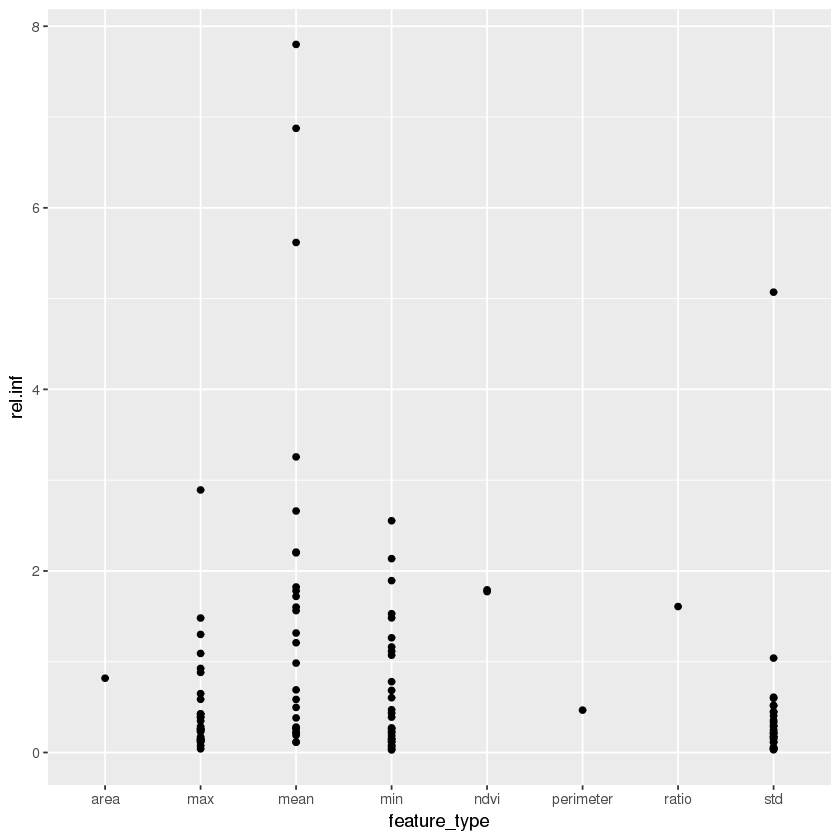

In [42]:
# which types of features are the best
#i.e. do max, min and std add anything to the model

getLastStringElement <- function(col, splitchar='_') {
  col <- as.character(col)
  split <- strsplit(col, split=splitchar)
  string.elements <- character(length(col))
  for (i in 1:length(col)) {
    string.elements[i] <- split[[i]][length(split[[i]])]
  }
  return (string.elements)
}

fit.gbm.summary$feature_type <- getLastStringElement(fit.gbm.summary$var)
ggplot(fit.gbm.summary, aes(feature_type, rel.inf)) + geom_point()

In [46]:
# derived parameters (i.e. perimeter / area ratio) can be more useful than
# the individual parameters alone, although random forest should be able to
# find interactions itself.
# Min/max and std do appear to add to model.